# 09 - Artifical neural networks 2

The goal of this exercise is to to develop an understanding how to tune the hyperparameter for a simple Artificial neural network using keras and scikit-learn.

<div class="alert alert-block alert-info">
To solve this notebook you need the knowledge from the previous notebook. If you have problems solving it, take another look at the last week's notebooks.
    
It's also recommended to read the chapter 10 of the book in advance.
</div>

**Task**: In this exercise, we want to predict the selling price of a used car.

<div class="alert alert-block alert-danger">
In this Jupyter-Notebook the hyperparameter tuning decribed in the 2nd edition of Geron's book using the Keras wrapper and RandomizedSearch is used. 
    Feel free to use the Keras Tuner as in the 3rd edition used. Take the steps described there. 
</div>


In [1]:
# Run this cell two import the following modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

<h2 style="color:blue" align="left">Load and preprocess the data</h2>

First, the data must be loaded. In the notebook on regression we have already used this data set. To compare the results, all preprocessing steps are applied again to get the same dataset.

In [2]:
df = pd.read_csv('dataset/car data.csv')
dataset = df[['Selling_Price', 'Present_Price', 'Kms_Driven']].copy()
dataset['Age'] = 2022 - df['Year']
dataset = dataset.join(pd.get_dummies(df[['Fuel_Type','Transmission','Seller_Type']], drop_first=True))
dataset_droped = dataset.drop(['Kms_Driven', 'Fuel_Type_Petrol'], axis=1)
dataset_droped

,Selling_Price,Present_Price,Age,Fuel_Type_Diesel,Transmission_Manual,Seller_Type_Individual
0,3.35,5.59,8,0,1,0
1,4.75,9.54,9,1,1,0
2,7.25,9.85,5,0,1,0
3,2.85,4.15,11,0,1,0
4,4.60,6.87,8,1,1,0
...,...,...,...,...,...,...
296,9.50,11.60,6,1,1,0
297,4.00,5.90,7,0,1,0
298,3.35,11.00,13,0,1,0
299,11.50,12.50,5,1,1,0


After the data has been preprocessed, the train-test split can be completed. Since the optimization of the neural network is very sensitive to the scale of the data, the features are first standardized.

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
X = dataset_droped.drop('Selling_Price',axis=1)
y = dataset_droped['Selling_Price']
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240, 5), (61, 5), (240,), (61,))

The following method can be applied for evaluation of the network's performance.

In [5]:
from sklearn.metrics import mean_squared_error, r2_score
def evaulate_model(model, X_test, y_test):
    pred_test = model.predict(X_test)
    # model metrics
    print('R^2 Test:', r2_score(y_test, pred_test))
    print('RMSE Test:', np.sqrt(mean_squared_error(y_test, pred_test)))
    # residual plot
    plt.scatter(pred_test, y_test)
    plt.xlabel('Predicted selling price')
    plt.ylabel('Actual selling price')
    plt.axline((0, 0), slope=1, color="black")
    upper_lim = 30
    plt.ylim([0,upper_lim])
    plt.xlim([0,upper_lim])

<h2 style="color:blue" align="left">Build a Model</h2>

In this notebook, we want to use scikit's RandomizedSearch for hyperparameter optimization. For this, a scikit-wrapper method is needed. In the book of Géron `tf.keras.wrappers.scikit_learn` is used for this. This is deprecated in the meantime. Instead, the use of the external package [`scikeras`](https://www.adriangb.com/scikeras/stable/) is recommended. To use it, it must first be installed via *pip*. Since this is a regression task, the KerasRegressor wrapper method must be used.

In [6]:
from scikeras.wrappers import KerasRegressor

To create a model, the KerasRegressor must be passed a function that creates and returns the model. The parameters of this function can be used later as hyperparmeter. In this case we want to adjust the number of hidden layers and the number of neurons per hidden layer.

In [7]:
def get_model(n_hidden=1, n_neurons=10): 
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=5))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    model.compile(loss="mse")
    return model

<div class="alert alert-block alert-success"><b>Task</b><br> 
Create a KerasRegressor with the parameters below. Then train it with 100 epochs with early stopping on the training dataset. Uses the test dataset for validation. 
</div>

Use this hyperparameters for the KerasRegressor:

``` python
    n_hidden=1
    n_neurons=10
    loss='mean_squared_error'
    optimizer='sgd'
    random_state=42
```

In [8]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

keras_reg = KerasRegressor(get_model())
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data = (X_test, y_test),
              callbacks = early_stopping_cb)
mse_test = keras_reg.score(X_test, y_test)
print('Test score:\t', mse_test)

Epoch 1/100
8/8 [==============================] - 0s 16ms/step - loss: 42.5654 - val_loss: 39.8314
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 41.4087 - val_loss: 38.8238
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 40.4544 - val_loss: 37.9139
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 39.5965 - val_loss: 37.1143
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 38.7914 - val_loss: 36.2604
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 37.9730 - val_loss: 35.4653
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 37.2065 - val_loss: 34.6718
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 36.3931 - val_loss: 33.8600
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 35.5995 - val_loss: 33.0594
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 34.7910 - val_loss: 32.1655
Epoch 11

2/2 [==============================] - 0s 1ms/step
R^2 Test: 0.9122451157166211
RMSE Test: 1.4217893845355805


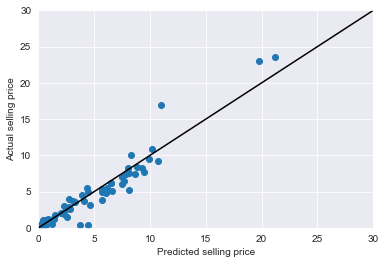

In [9]:
evaulate_model(keras_reg, X_test, y_test)

<h2 style="color:blue" align="left">Hyperparameter-Tuning</h2>

Now we can initialize a RandomizedSearch with the trained scikit wrapper `keras_reg`.

In [10]:
from sklearn.model_selection import RandomizedSearchCV

The following command shows all parameters which can be set.

In [11]:
keras_reg.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])

<div class="alert alert-block alert-success"><b>Task</b><br> 
Perform a hyperparameter search with the RandomSearchCV on scikit. Use a 3-fold crossvalidation and test at least 10 different parameter sets. To achieve comparable results, use 42 as random_state. Train with at least 100 epochs and use early stopping.
</div>

# TODO: find out why building of optimizer is failing

In [12]:
params = {
    "n_hidden": np.arange(1,15),
    "n_neurons":np.arange(1,200),
    "loss": ["mean_squared_error"],
    "optimizer": ["adam", "sgd"],
    "optimizer__learning_rate": [0.001, 0.01, 0.01]
}

rs = RandomizedSearchCV(keras_reg, params, n_iter=10, cv=3)
rs.fit(X_train, y_train, epoch=100,
       validation_data=(X_test, y_test),
       callbacks=early_stopping_cb)

INFO:tensorflow:Assets written to: ram://ec0bd1b6047344d388b2c3ea9be633d9/assets


AttributeError: 'RMSprop' object has no attribute 'build'

In [ ]:
rs.best_params_

Now can recreate the model with the best parameter for prediction.

In [ ]:
best_reg = KerasRegressor(get_model,
                         n_hidden=rs.best_params_["n_hidden"],
                         n_neurons=rs.best_params_["n_neurons"],
                         optimizer=rs.best_params_["optimizer"],
                         optimizer__learning_rate=rs.best_params_["optimizer__learning_rate"],
                         loss=rs.best_params_["loss"],
                         random_state=42)

best_reg.fit(X_train, y_train, epochs=200,
                    validation_data=(X_test, y_test),
                    callbacks=early_stopping_cb)

In [ ]:
evaulate_model(best_reg, X_test, y_test)

<h2 style="color:blue" align="left">Save the Model</h2>

There are two formats you can use to save an entire model to disk: the `TensorFlow SavedModel format`, and the older `Keras H5 format`. Géron's book still uses the outdated format. The recommended format is now SavedModel. It is the default when you use model.save().

<div class="alert alert-block alert-success"><b>Task</b><br> 
Use the save() method of keras to save to model to disk using the SavedModel format. You can access the model of the keras 
</div>

AttributeError: 'KerasRegressor' object has no attribute 'save'

The saved model includes:

- The model's architecture/config
- The model's weight values (which were learned during training)
- The model's compilation information (if compile() was called)
- The optimizer and its state, if any (this enables you to restart training where you left)

For further information have a look at the [documentation](https://www.tensorflow.org/guide/keras/save_and_serialize) of TensorFlow.